#  Forecasting taxi orders

The taxi aggregator has collected historical data on taxi orders at airports. To attract more drivers during peak load, you need to predict the number of taxi orders for the next hour.

## Data preparation

In [39]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot  as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from statsmodels.regression import linear_model
from patsy import dmatrices
from sklearn.ensemble import RandomForestRegressor
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.arima.model import ARIMA as ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from lightgbm import LGBMRegressor

In [40]:
warnings.filterwarnings('ignore')
sns.set()

In [41]:
df = pd.read_csv('taxi.csv',
                 index_col=[0],
                 parse_dates=[0])
print(df.index.is_monotonic)

True


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [43]:
df.index.duplicated().sum()

0

In [44]:
df['rolling'] = df.rolling(6).mean()

<AxesSubplot:xlabel='datetime'>

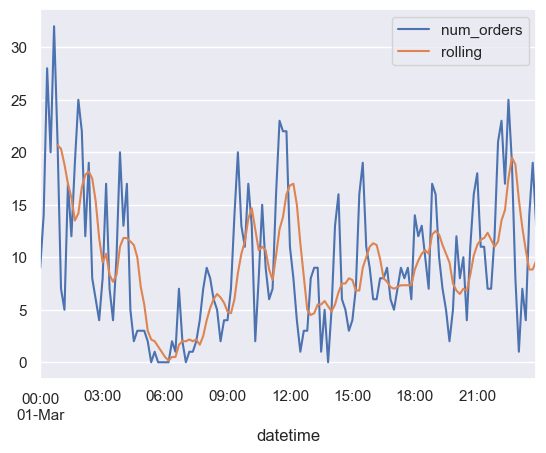

In [45]:
df[:24*6].plot()

There are no gaps or duplicates in the data. We will make a resample for one hour, since we will need to find the total number of orders, then we will summarize.

In [46]:
data = df.resample('1H').sum()

In [47]:
data.index[0]

Timestamp('2018-03-01 00:00:00', freq='H')

In [48]:
data.index[-1]

Timestamp('2018-08-31 23:00:00', freq='H')

<AxesSubplot:xlabel='datetime'>

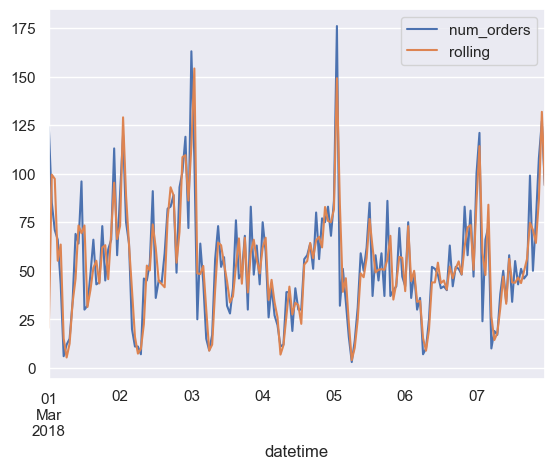

In [49]:
data[:24*7].plot()

## Data analyses

The data is presented for 6 months, from March to the end of August

Decompose the time series into trend, seasonality and remainder

In [50]:
decompose = seasonal_decompose(data['num_orders'])

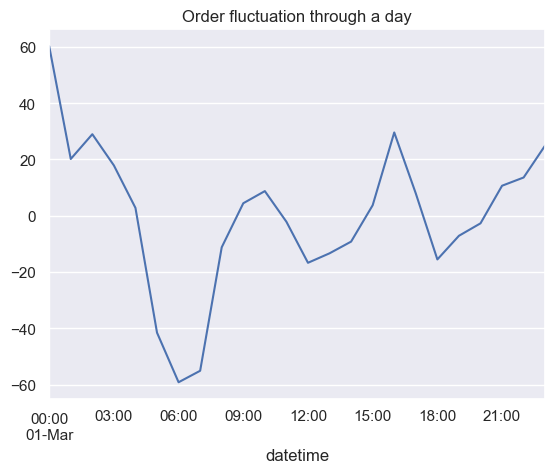

In [51]:
decompose.seasonal[:24].plot()
plt.title('Order fluctuation through a day')
plt.show()

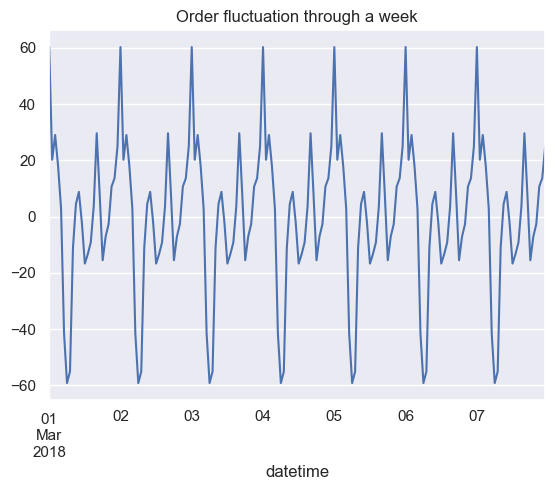

In [52]:
decompose.seasonal[:24*7].plot()
plt.title('Order fluctuation through a week')
plt.show()

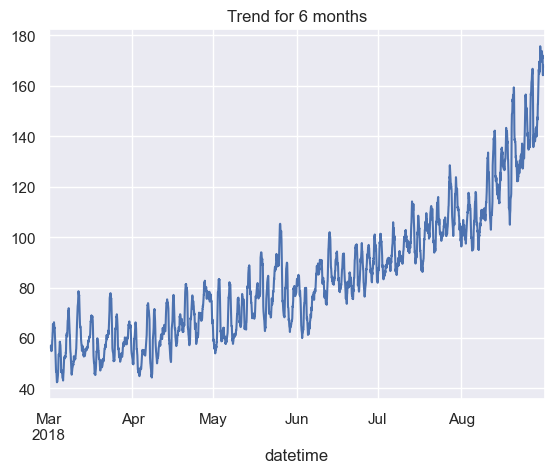

In [53]:
decompose.trend.plot()
plt.title('Trend for 6 months')
plt.show()

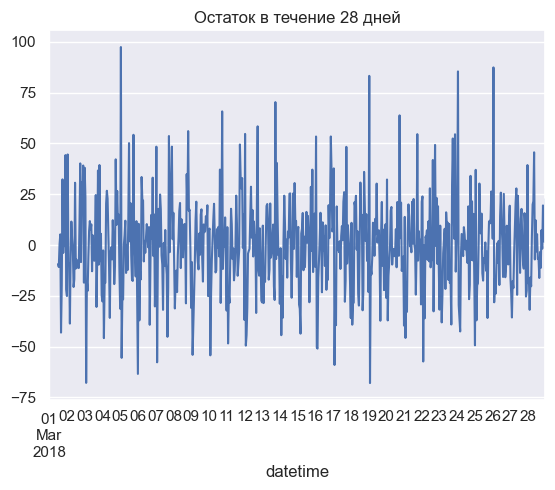

In [16]:
decompose.resid[:24*7*4].plot()
plt.title('residue for 28 days')
plt.show()

The time series shows that the demand for taxis is constantly growing, and the seasonality of demand during the day and week is also visible. The least orders are early in the morning, when people do not go to work, but also do not return from night shifts or clubs. Therefore, we will add two columns with the hour and day of the week as new signs. We will also add a time offset from 1 to 48 hours. It can be seen that Friday evening is the hottest time.

In [17]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data['rolling'] = data['num_orders'].shift().rolling(3).mean()
for lag in range(1, 169):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data = data.dropna()

Let's check if we can consider the time series as stationary. We will apply the Dickey-Fuller test. In this case, the hypotheses are formulated as follows:

The null hypothesis assumes that the process is non-stationary.
The alternative hypothesis, accordingly, suggests the opposite.

In [18]:
adf_test = adfuller(data['num_orders'])
print('p-value = ' + str(adf_test[1]))

p-value = 0.03170155446485111


P-value is less 5%, we could consider that the series is stationary

Prepare data

In [19]:
target = data['num_orders']
feature = data.drop('num_orders',axis=1)

In [20]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, target,shuffle=False,test_size=.2)
feature_valid, feature_test, target_valid, target_test = train_test_split(feature_test, target_test,shuffle=False,test_size=.5)

Let's plot an autocorrelation curve. It shows that every 24 hours there is a peak of correlation, which again indicates a period of 24 hours

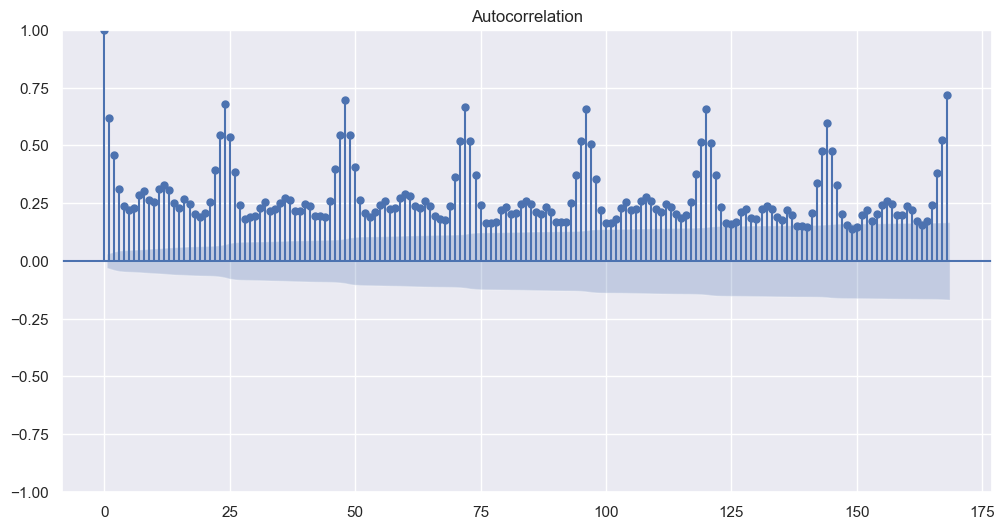

In [21]:
fig, ax1 = plt.subplots(figsize=(12,6))
plot_acf(target, lags=24*7,ax=ax1);

## Model training

Start with **SARIMAX**

In [22]:
model = SARIMAX(target_train, 
                order = (0, 0, 0), 
                seasonal_order = (2, 1, 0, 24))
sarimax_fit = model.fit()

In [23]:
predict = sarimax_fit.predict(target_valid.index[0],target_valid.index[-1])

RMSE =  34.78879196337479


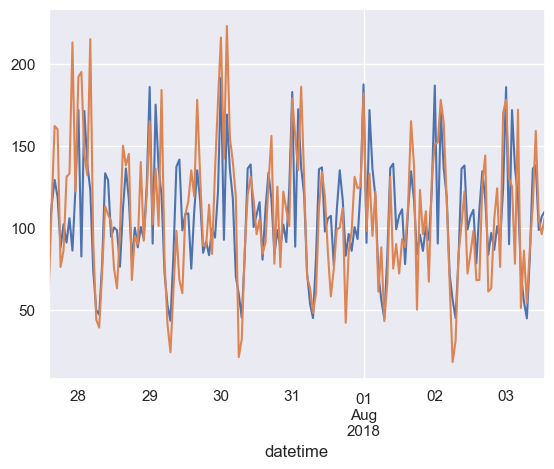

In [24]:
predict[:24*7].plot()
target_valid[:24*7].plot()
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict)))

Train **linear regression**

In [25]:
model_lr = LinearRegression()# < обучите модель >
model_lr.fit(feature_train,target_train)
predict_lr = pd.DataFrame(model_lr.predict(feature_valid),index=target_valid.index)

RMSE =  29.185562946843557


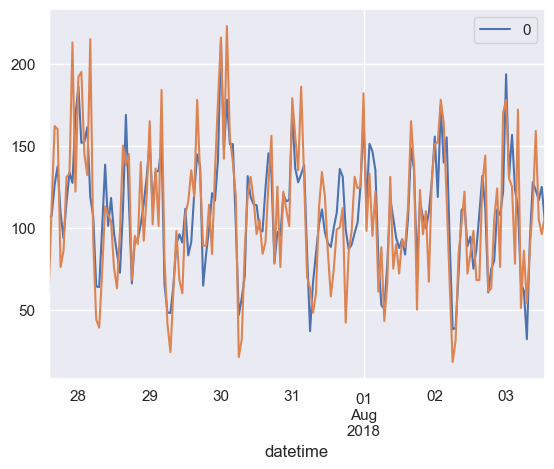

In [26]:
predict_lr[:24*7].plot()
target_valid[:24*7].plot()
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_lr)))

Train **random forest**

In [27]:
%%time
model = RandomForestRegressor()
param_search = {'max_depth' : range(3,12,2),'n_estimators' : (100,200,300)}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model,
                       cv=tscv,
                       param_grid=param_search)
grid_result = gsearch.fit(feature_train, target_train)
best_params = grid_result.best_params_

CPU times: total: 15min 1s
Wall time: 15min 3s


In [28]:
random_forest = RandomForestRegressor(max_depth=best_params["max_depth"],
                                      n_estimators=best_params["n_estimators"],
                                      random_state=123)

In [29]:
%%time
random_forest.fit(feature_train,target_train)

CPU times: total: 2min 5s
Wall time: 2min 5s


RandomForestRegressor(max_depth=11, n_estimators=300, random_state=123)

In [30]:
predict_rf = pd.DataFrame(random_forest.predict(feature_valid),index=target_valid.index)

RMSE =  30.589354402797728


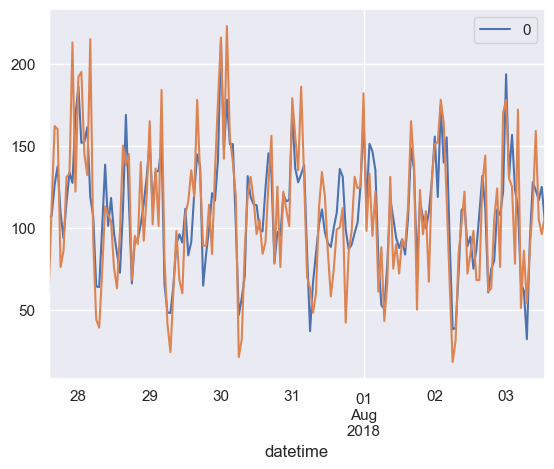

In [31]:
predict_lr[:24*7].plot()
target_valid[:24*7].plot()
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_rf)))

Train **LGMB regressor**

In [32]:
%%time
model_lgb = LGBMRegressor(random_state=123, objective='mean_squared_error')
param_search = {'n_estimators' : range(70,300,30),'max_depth' : [-1] + list(range(10,30,5))}
tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model_lgb,
                       cv=tscv,
                       param_grid=param_search)
grid_result_lgb = gsearch.fit(feature_train, target_train)
best_params_lgb = grid_result_lgb.best_params_
lgb = LGBMRegressor(n_estimators=best_params["n_estimators"],
                    max_depth=best_params['max_depth'],
                    random_state=123)

CPU times: total: 6min 54s
Wall time: 1min


In [33]:
%%time
lgb.fit(feature_train,target_train)

CPU times: total: 14.4 s
Wall time: 2.26 s


LGBMRegressor(max_depth=11, n_estimators=300, random_state=123)

RMSE =  29.7866251723116


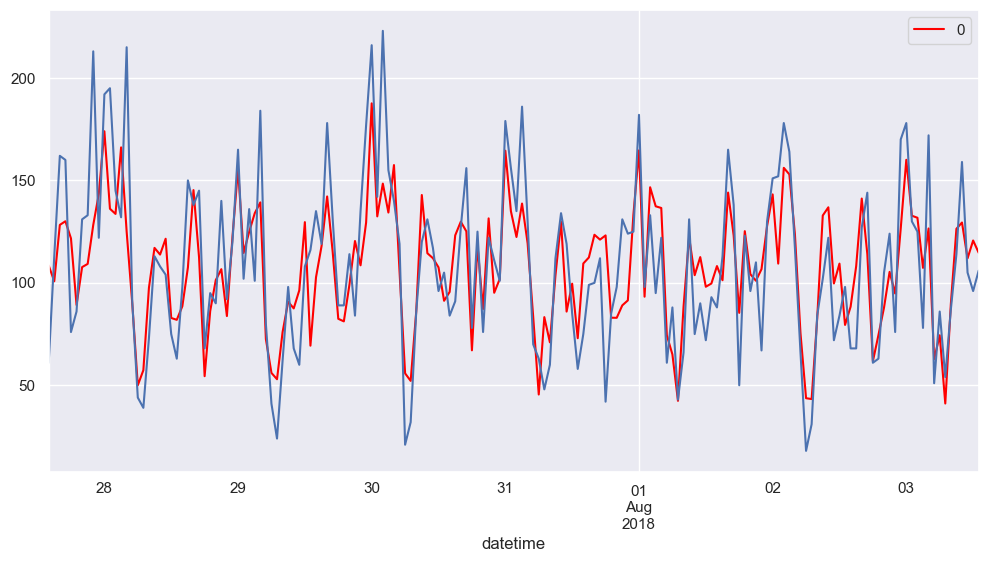

In [34]:
predict_lgb = pd.DataFrame(lgb.predict(feature_valid),index=target_valid.index)
fig, ax1 = plt.subplots(figsize=(12,6))
predict_lgb[:24*7].plot(ax=ax1,color='red')
target_valid[:24*7].plot(ax=ax1)
print('RMSE = ',np.sqrt(mean_squared_error(target_valid,predict_lgb)))

Model **LGBMRegressor** showed the best RMSE=31

Test it

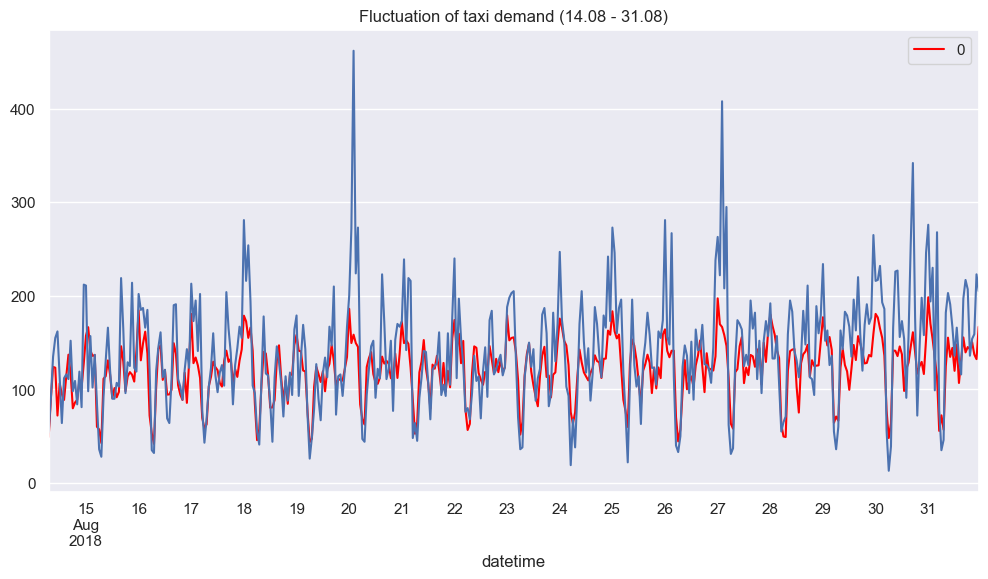

In [37]:
predict_lgb_test = pd.DataFrame(lgb.predict(feature_test),index=target_test.index)
fig, ax1 = plt.subplots(figsize=(12,6))
predict_lgb_test.plot(ax=ax1,color='red')
target_test.plot(ax=ax1)
plt.title('Fluctuation of taxi demand (14.08 - 31.08)')
plt.show()

In [38]:
print('RMSE = ',np.sqrt(mean_squared_error(target_test,predict_lgb_test)))

RMSE =  44.610835922482536


**Conclusion**

During the project, a dataset with a time series for predicting taxi demand was prepared. Four regression models were selected: SARIMAX, linear regression, random forest, and LGBM. The best model turned out to be the LGBM model with an RMSE of 44. The model accurately predicted the fluctuations in the time series. A periodicity of 24 hours is evident, as well as the main trends of increasing demand in the evening and decreases in the morning. The main thing that the model failed to predict is the peaks on August 20th and 27th, which are both Mondays. These peaks cannot be explained, which is why the model didn't predict them.